In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
from math import ceil

from utils import SECTORS, DR_PRICES, NG_PRICES, SECTOR_NICE_NAMES, DR_PRICE_NICE_NAMES, NAT_GAS_NICE_NAMES, get_datapoint

In [74]:
# User defined variables
METHOD = "static" # "static" | "dynamic"
REGION = "new_england" # "caiso" | "new_england"
AS_PERCENTAGE = True # display heatmaps as percentage of base case
CMAP_OVERRIDE = None # https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [75]:
# Path handling (DO NOT CHANGE)
FIGURES_BASE = Path("..","figures","heatmaps")
FIGURES_METHOD = Path(FIGURES_BASE, REGION, METHOD)

In [76]:

# Formatting (DO NOT CHANGE)
OBJ_COST_SCALER = 1 if AS_PERCENTAGE else 1e9
PEAKINESS_SCALER = 1 if AS_PERCENTAGE else 1e3
PEAK_NET_LOAD_SCALER = 1 if AS_PERCENTAGE else 1e3
RAMPING_SCALER = 1 if AS_PERCENTAGE else 1e3
CAPACITY_SCALER = 1 if AS_PERCENTAGE else 1e3
EMISSIONS_SCALER = 1 if AS_PERCENTAGE else 1e6

CMAP = CMAP_OVERRIDE if CMAP_OVERRIDE else "coolwarm" if AS_PERCENTAGE else "crest"

OBJ_COST_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "($B)"
PEAKINESS_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "(GW)"
PEAK_NET_LOAD_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "(GW)"
RAMPING_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "(GW)"
CAPACITY_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "(GW)"
EMISSIONS_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "(MMT CO2e)"

SHARE_YLABEL = True if AS_PERCENTAGE else False

In [77]:
def get_template_dataframe(include_base: bool = False) -> pd.DataFrame:
    prices = DR_PRICES.copy()
    if include_base:
        prices.insert(0, "None")
    sectors = SECTORS.copy()
    if include_base:
        sectors.insert(0, "None")
    return pd.DataFrame([],
        index=sectors,
        columns=prices
    )
get_template_dataframe(include_base=False)

,high,mid,low,vlow
e,NaN,NaN,NaN,NaN
t,NaN,NaN,NaN,NaN
et,NaN,NaN,NaN,NaN


In [78]:
def get_heatmap_data(result: str, metric: str, as_percentage: bool = False) -> dict[str, pd.DataFrame]:
    data = {}
    for ng_price in NG_PRICES:
        include_base = False if as_percentage else True
        hm = get_template_dataframe(include_base=include_base)
        for sector, dr_price in product(SECTORS, DR_PRICES):
            df = get_datapoint(
                region=REGION,
                ng_price=ng_price,
                result=result,
                sector=sector,
                dr_price=dr_price,
                method=METHOD
            )
            datapoint = df.at[metric, "value"]
            hm.at[sector, dr_price] = datapoint
        df = get_datapoint(region=REGION, ng_price=ng_price, result=result)
        datapoint = df.at[metric, "value"]
        if as_percentage:
            hm = (hm - datapoint).div(datapoint).mul(100).round(2)
        else:
            datapoint = df.at[metric, "value"]
            hm.at["None", "None"] = datapoint
        data[ng_price] = hm.astype(float)
    return data

In [79]:
def generate_heatmap(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 2
    nrows = ceil(3 / ncols)
    
    ylabel = kwargs.get("ylabel", "")
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    
    row = 0
    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    for gas_price, df in data.items():
        
        df = df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        else:
            title = NAT_GAS_NICE_NAMES[gas_price]
        
        df = df.div(scaler).round(2)
        
        hm = sns.heatmap(df, annot=True, cmap="crest", ax=axs[row, col], fmt=".1f")
        
        if ylabel:
            colorbar = hm.collections[0].colorbar
            colorbar.ax.set_ylabel(ylabel, rotation=0, labelpad=10, y=-0.05)
        
        axs[row, col].set_title(title, fontsize=14)
        axs[row, col].tick_params(axis="y", labelrotation=0)
        
        col += 1
        if col > 1:
            col = 0
            row += 1
        
    if col != 0:
        axs[row, 1].axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

In [80]:
def generate_heatmap_3col(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, share_ylabel: Optional[bool] = False, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 3
    nrows = 1
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    ylabel = kwargs.get("ylabel", "")
    
    cmap = kwargs.get("cmap", "viridis")
    
    if share_ylabel:
        all_values = pd.concat(
            [df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES).div(scaler).stack()
             for df in data.values()]
        )
        vmin, vmax = all_values.min(), all_values.max()
    else:
        vmin = vmax = None
    
    heatmaps = [] # for shared colorbar
    
    for gas_price, df in data.items():
        
        df = df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        else:
            title = NAT_GAS_NICE_NAMES[gas_price]
        
        df = df.div(scaler).round(2)
        
        if col == 0:
            yticklabels = True
        else:
            yticklabels = False
            
        hm = sns.heatmap(
            df, 
            annot=True, 
            cmap=cmap,
            cbar=False if share_ylabel else True,
            ax=axs[col], 
            fmt=".1f", 
            yticklabels=yticklabels,
            annot_kws={
                "fontsize":"x-large"
            },
            vmin=vmin,
            vmax=vmax
        )
        heatmaps.append(hm)

        if not share_ylabel:
            colorbar = hm.collections[0].colorbar
            colorbar.ax.tick_params(labelsize=14)
            if ylabel:
                colorbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
        
        axs[col].set_title(title, fontsize=18, pad=20)
        
        axs[col].tick_params(axis="y", labelrotation=0, labelsize=14)
        axs[col].tick_params(axis="x", labelrotation=45, labelsize=14)
        
        col += 1
        
    fig.supxlabel("Demand Response Sector", fontsize =18)
    fig.supylabel("Demand Response Cost", fontsize =18)
        
    fig.tight_layout(rect=[0.02, 0, 0.80, 1])
        
    if share_ylabel:
        cbar = fig.colorbar(
            heatmaps[0].collections[0],
            ax=axs,
            orientation="vertical",
            fraction=0.02,
            pad=0.02
        )
        cbar.ax.tick_params(labelsize=14)
        if ylabel:
            cbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
        
        
    return fig, axs

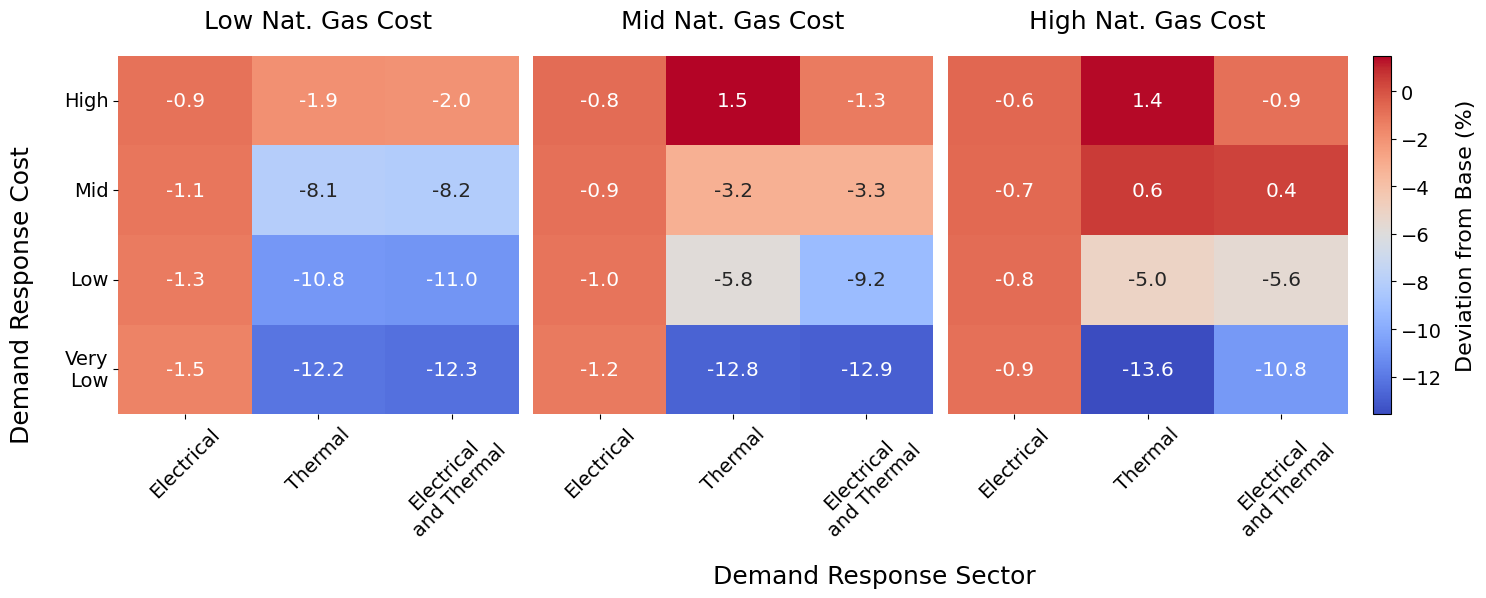

In [81]:
data = get_heatmap_data("cost", "objective_adj", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "objective_adj.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

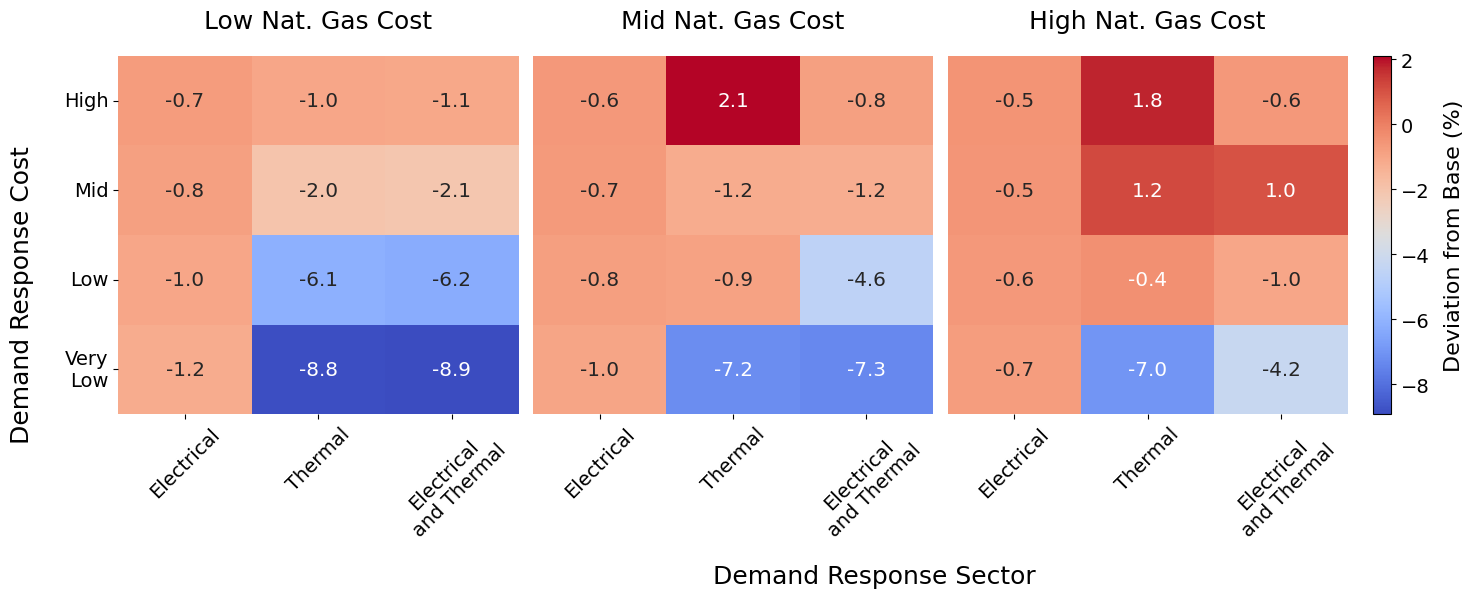

In [82]:
data = get_heatmap_data("cost", "objective", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "objective.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

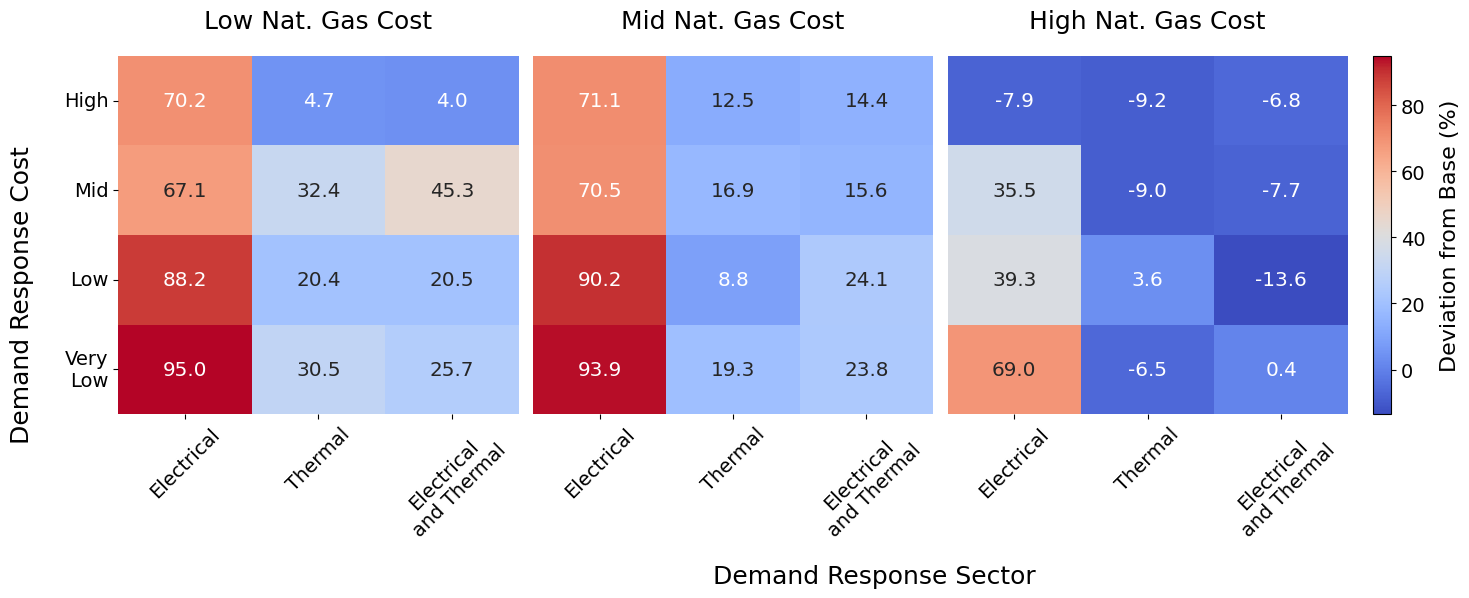

In [83]:
data = get_heatmap_data("peakiness", "peakiness", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=PEAKINESS_SCALER, title="", ylabel=PEAKINESS_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "peakiness.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

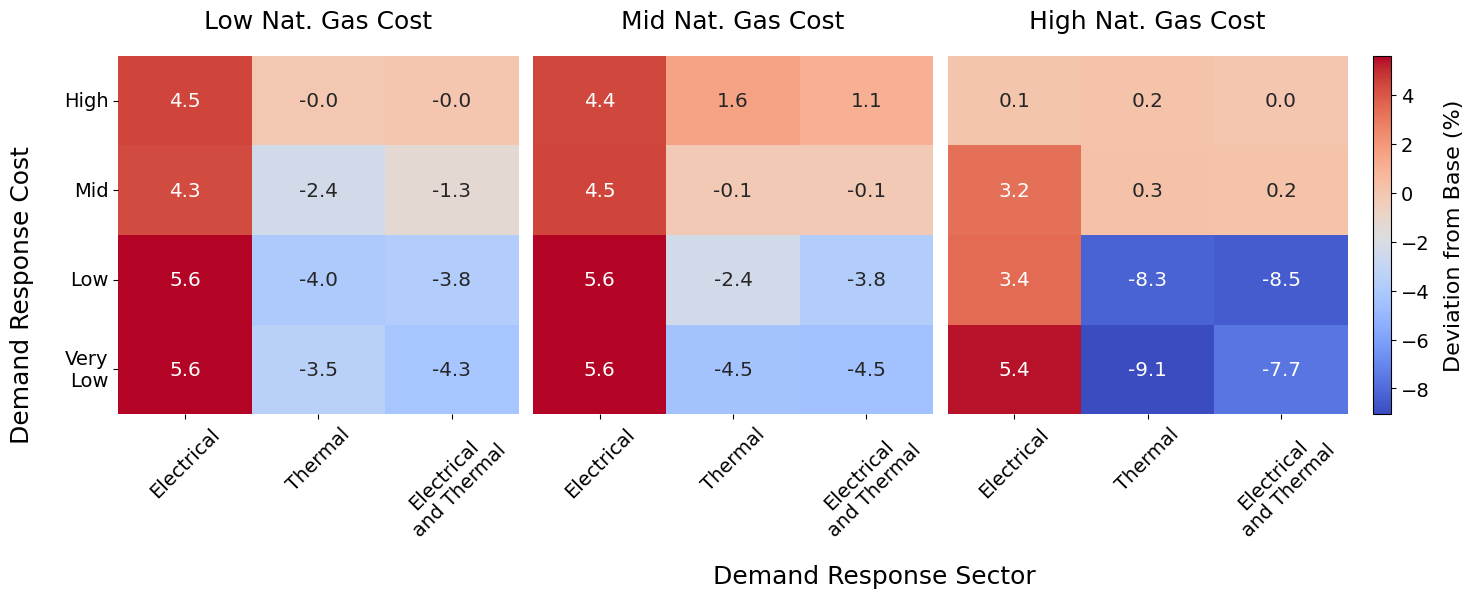

In [84]:
data = get_heatmap_data("peakiness", "peak", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=PEAK_NET_LOAD_SCALER, title="", ylabel=PEAK_NET_LOAD_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "peak_net_load.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

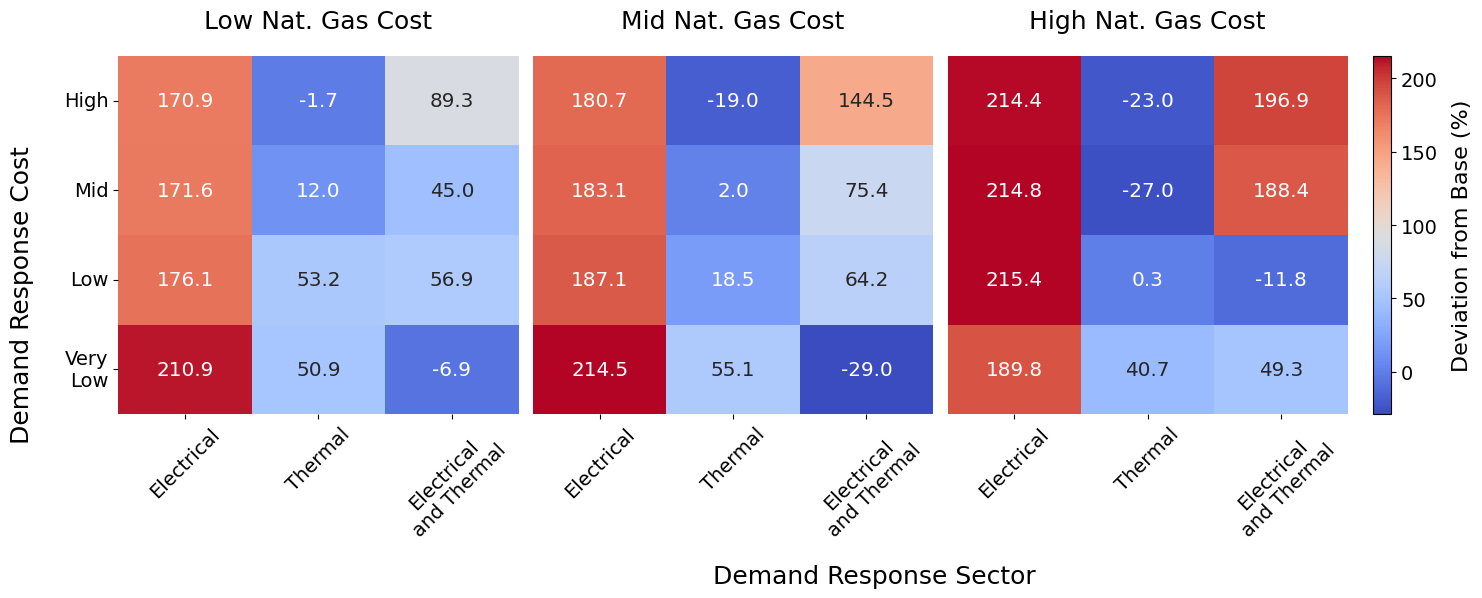

In [85]:
data = get_heatmap_data("ramping", "extreme", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=RAMPING_SCALER, title="", ylabel=RAMPING_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "extreme_ramping.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

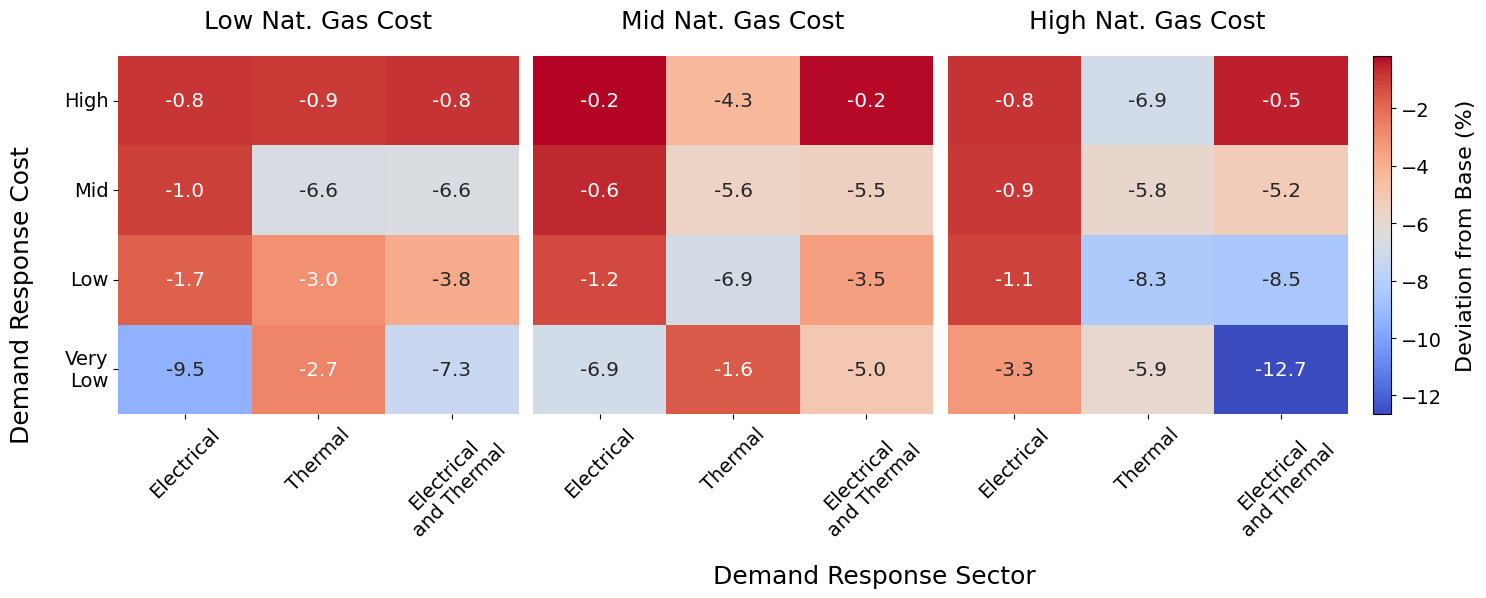

In [86]:
data = get_heatmap_data("ramping", "rountine", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=RAMPING_SCALER, title="", ylabel=RAMPING_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "routine_ramping.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

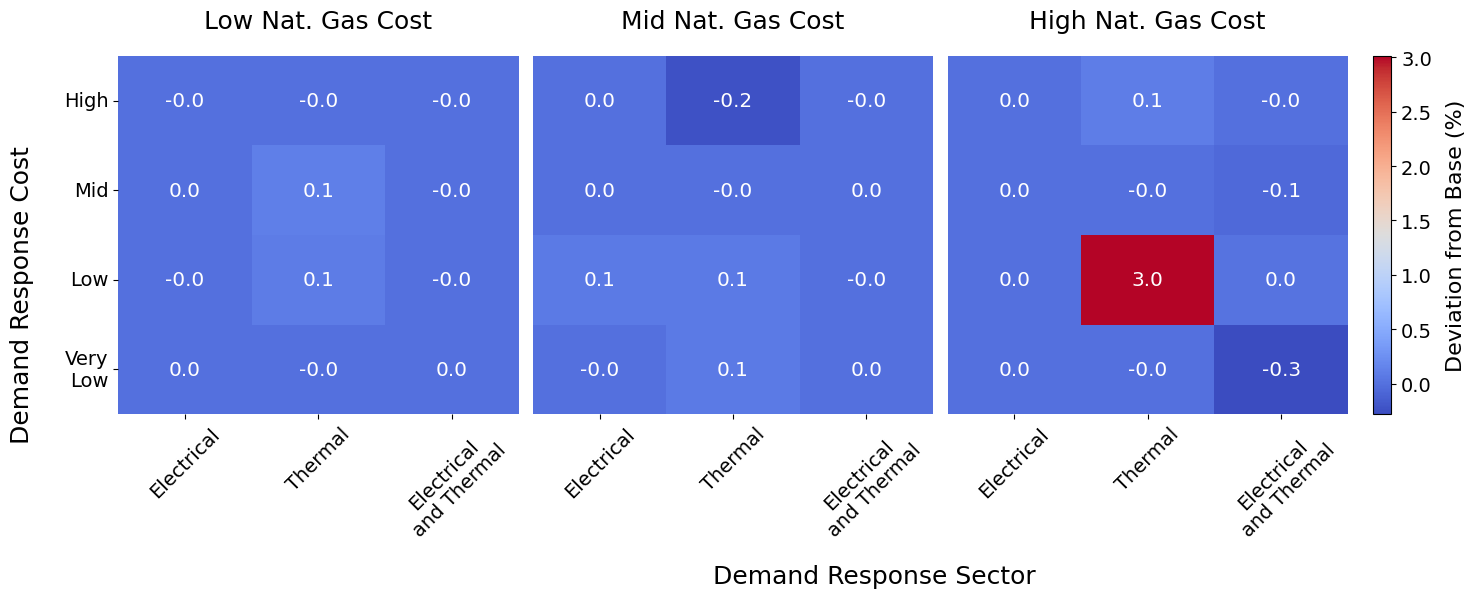

In [87]:
data = get_heatmap_data("capacity", "Wind", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "wind_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

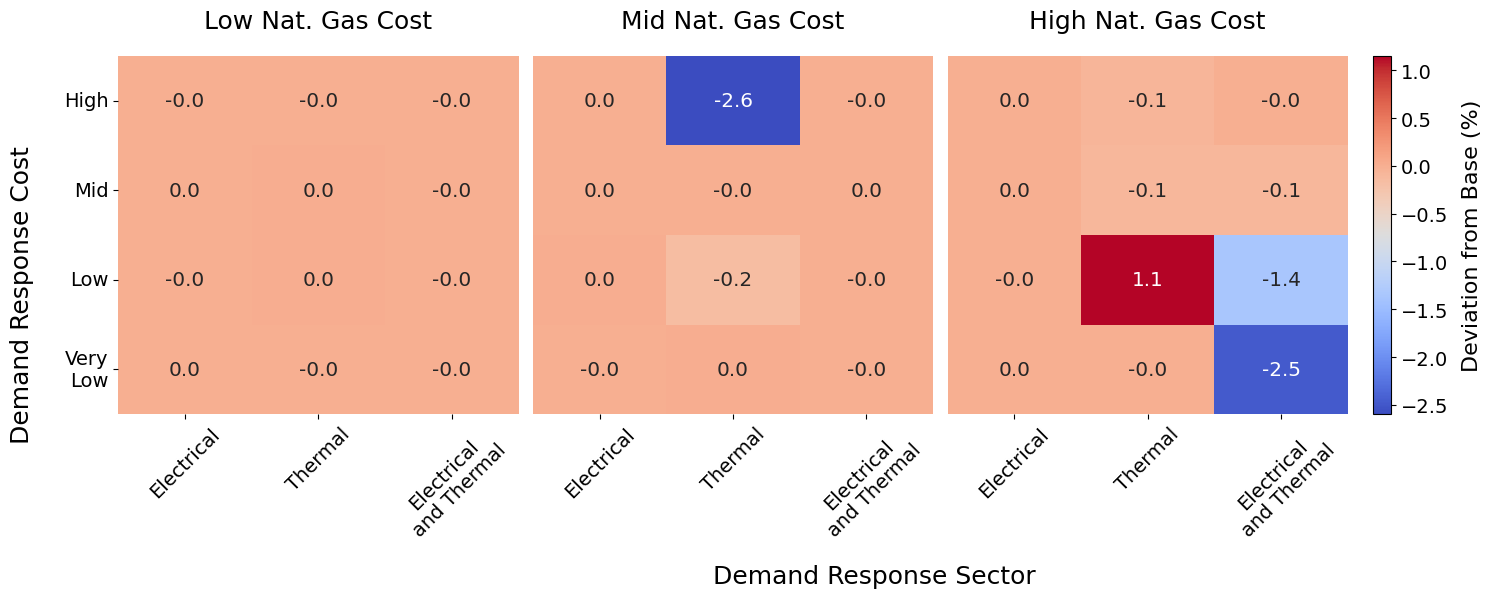

In [88]:
data = get_heatmap_data("capacity", "Solar", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "wind_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

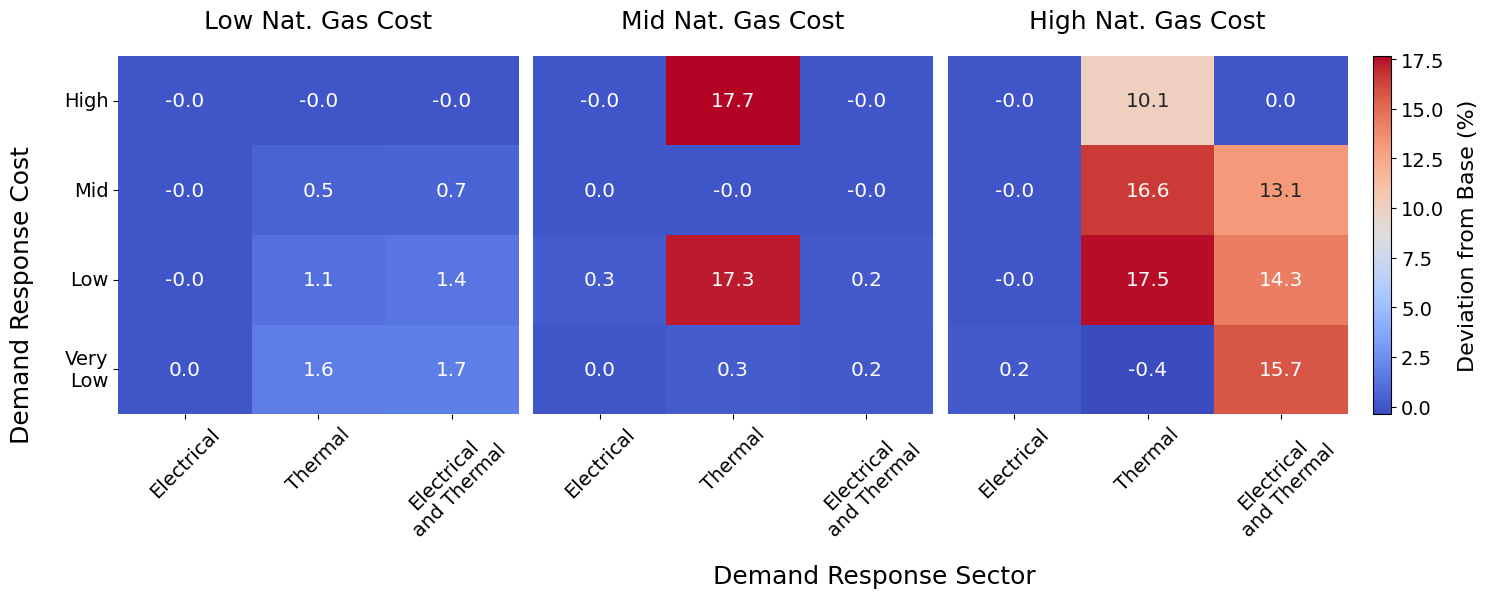

In [89]:
data = get_heatmap_data("capacity", "Transport Electric", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "transport_electric.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

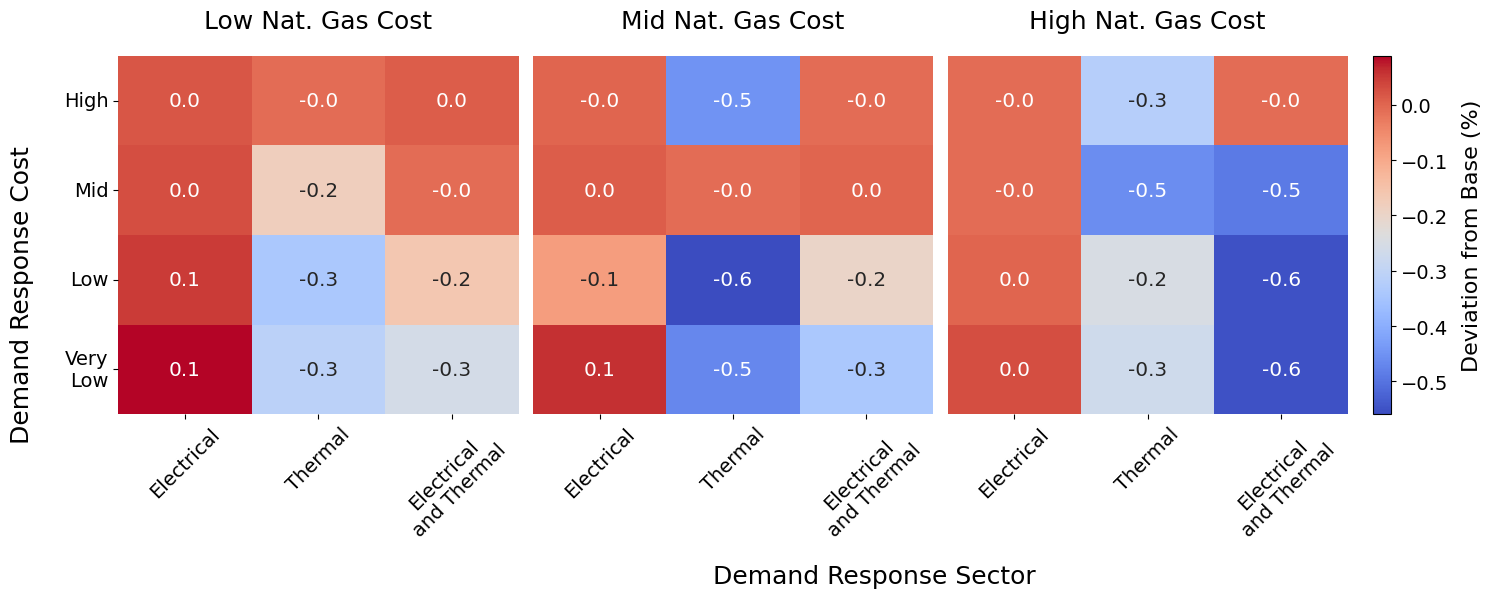

In [90]:
data = get_heatmap_data("capacity", "Transport Electric Light", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "lgt_evs.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

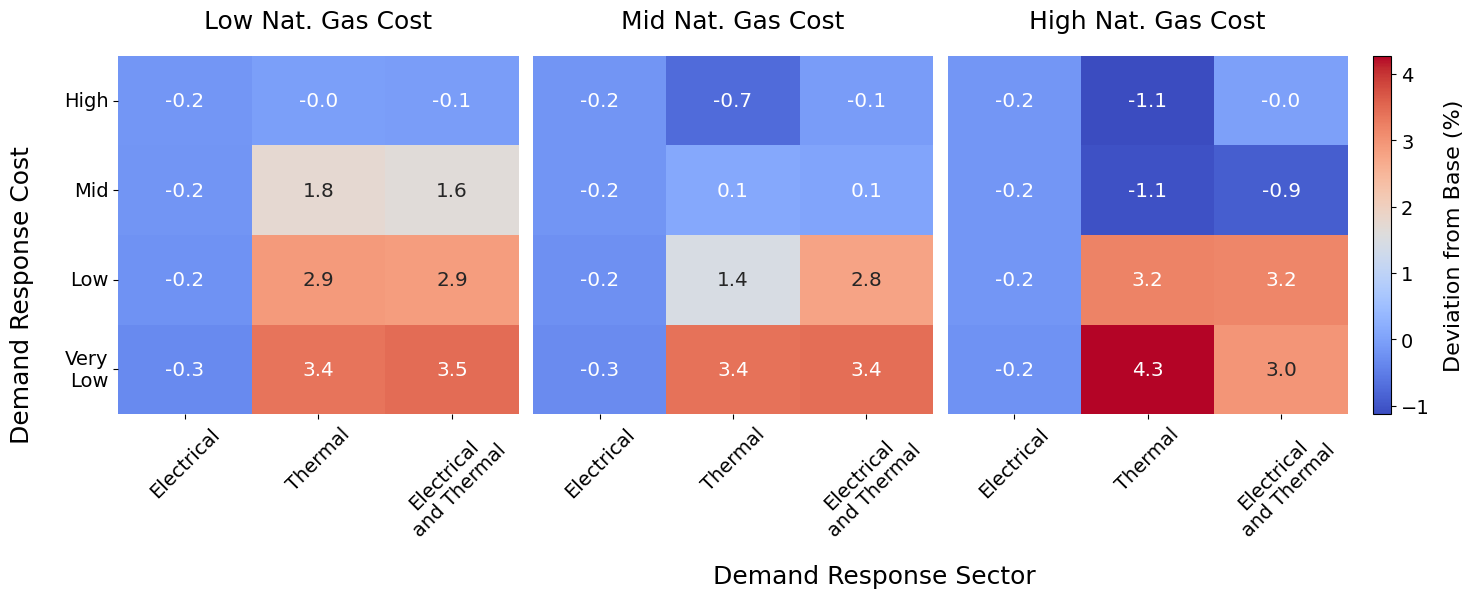

In [91]:
data = get_heatmap_data("capacity", "Service Gas Furnace", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "service_gas_furnace.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

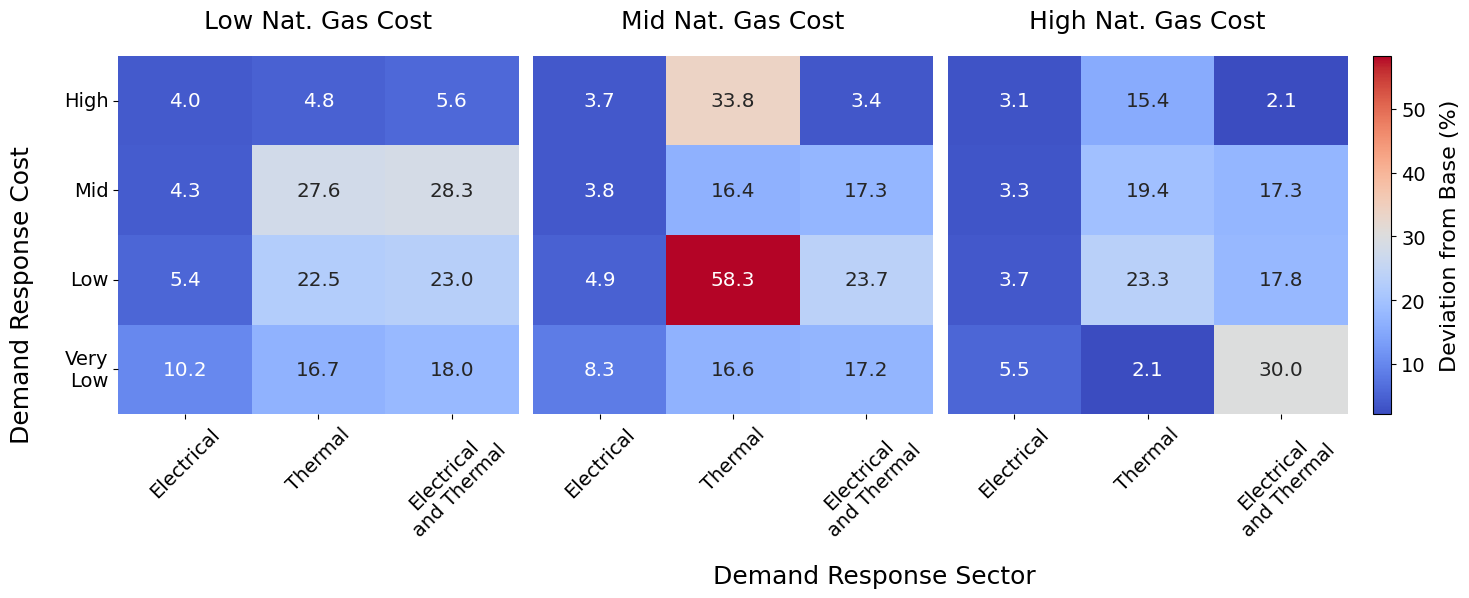

In [92]:
data = get_heatmap_data("capacity", "Service Heat Pump", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "service_heat_pump.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

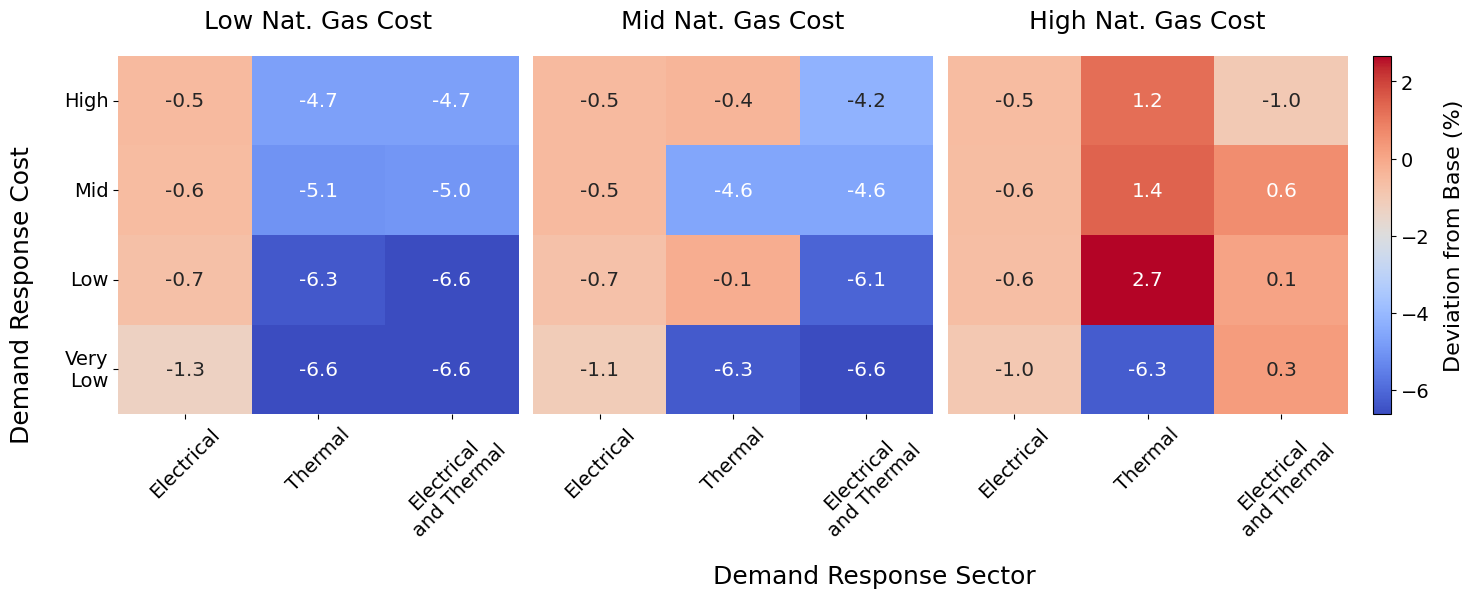

In [93]:
data = get_heatmap_data("capacity", "Service Air Conditioner", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "service_air_conditioner.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

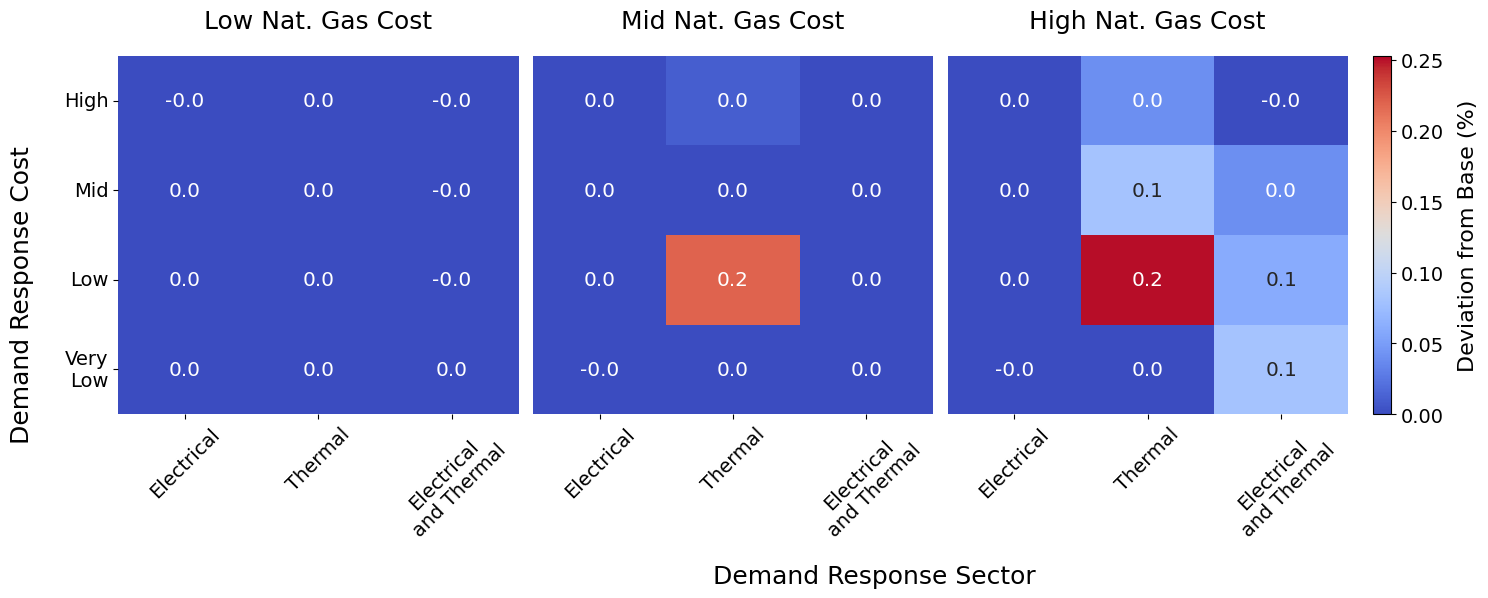

In [94]:
data = get_heatmap_data("capacity", "Natural Gas OCGT", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "ocgt_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

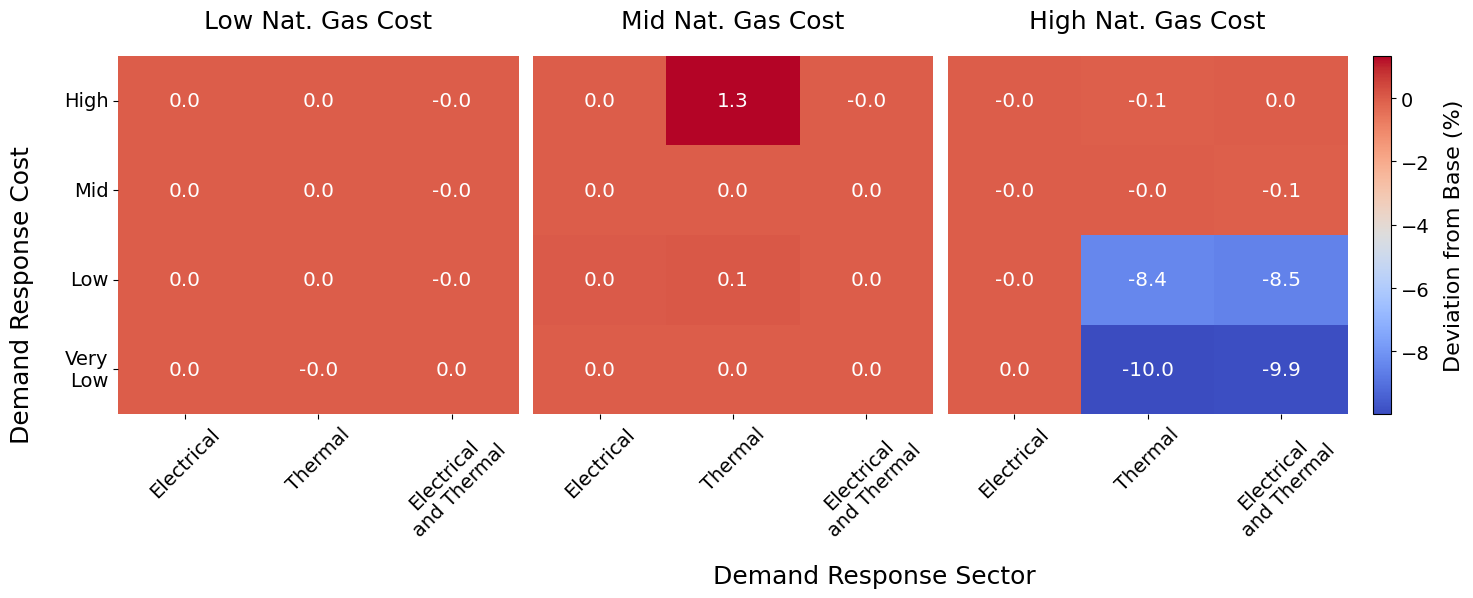

In [95]:
data = get_heatmap_data("capacity", "Natural Gas CCGT", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=CAPACITY_SCALER, title="", ylabel=CAPACITY_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "ccgt_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

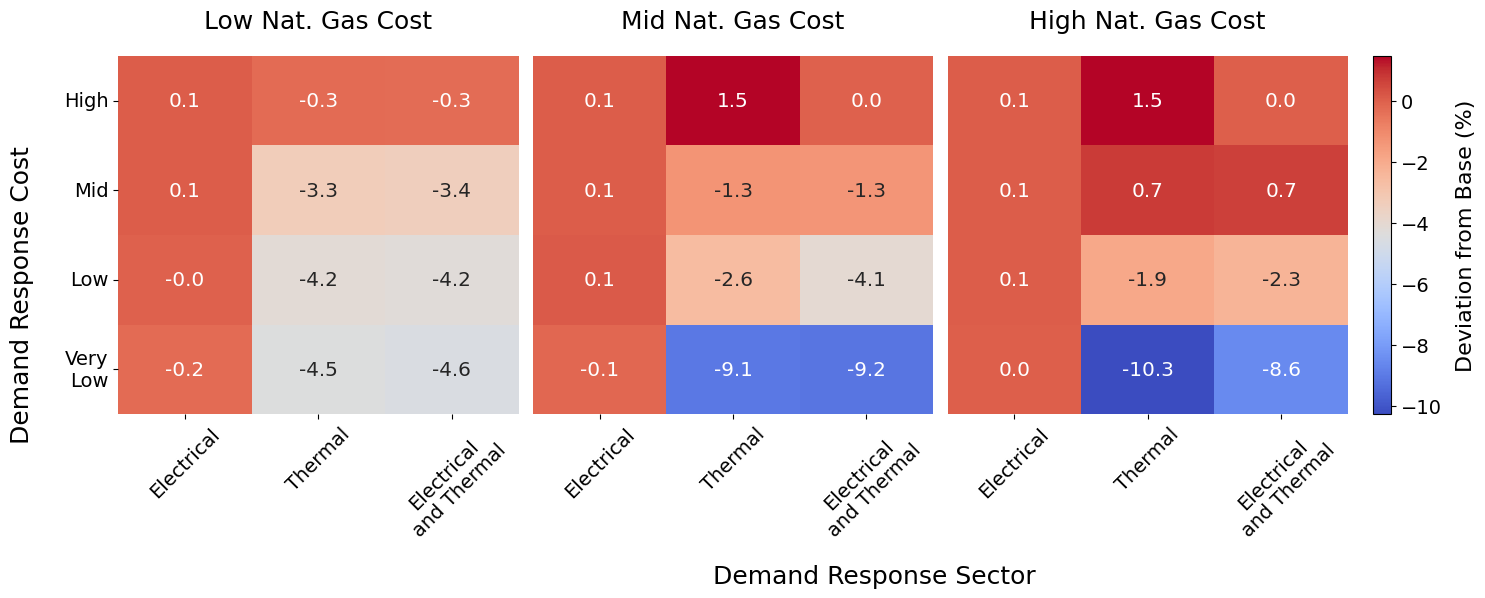

In [96]:
data = get_heatmap_data("emissions", "Emissions CO2 T", as_percentage=AS_PERCENTAGE)
fig, _ = generate_heatmap_3col(data, scaler=EMISSIONS_SCALER, title="", ylabel=EMISSIONS_LABEL, share_ylabel=True, cmap=CMAP)
save_f = Path(FIGURES_METHOD, "emissions.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")